In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
from google.colab import drive, output
drive.mount('/content/drive')
%load_ext autoreload
%autoreload 1
sys.path.append('/content/drive/MyDrive/Jaguas_2018')
%cd '/content/drive/MyDrive/Jaguas_2018'
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1nfTdDkppiuyI6pOFb93wUYtK8j6DA0cv/Jaguas_2018


##Librerias

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 
import librosa
import os
from pathlib import Path
import librosa.display
from librosa.display import specshow
import pickle
from IPython.display import Audio #reproducir audio

#Obtener PSD(Power Spectral Density)solo para un audio

##cargar ruta y audios

In [4]:
root_path = '/content/drive/MyDrive/Jaguas_2018'
folders = os.listdir(root_path)
files = []
for i in range(len(folders)):
    path_aux = "{}/{}".format(root_path, folders[i])
    files += list(Path(path_aux).rglob("*.{}".format("wav")))

filename = str(files[12000])

print(filename)


/content/drive/MyDrive/Jaguas_2018/G28_m/G28_20180610_164800.wav


##Obtener PSD(Power Spectral Density) densidad espectral de potencia

In [ ]:
n_fft = 1024
y, sr = librosa.load(filename, sr=44100)
S = librosa.stft(y, n_fft=n_fft)
psd=np.abs(S)**2
P = np.mean(psd, axis=1)

plt.psd(y)

<ipython-input-8-deba0d085397>:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),


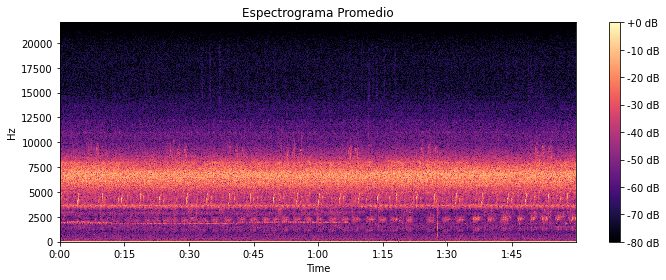

In [8]:
# Graficar el espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='linear', x_axis='time', sr=sr, hop_length=512)
plt.title('Espectrograma Promedio')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/PSD/espectrograma_G50_m.pdf", format="pdf")
plt.show()

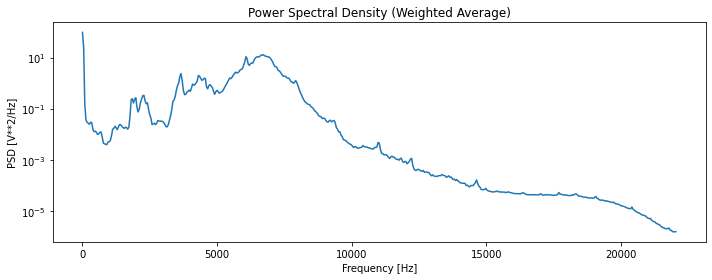

In [6]:

f = librosa.fft_frequencies(sr=44100, n_fft=1024)
plt.figure(figsize=(10,4))
plt.semilogy(f, np.mean(psd, axis=1))#foma logariotmica
plt.title('Power Spectral Density (Weighted Average)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/PSD/psd_G50_m.pdf", format="pdf")
plt.show()

In [ ]:
S.shape

(513, 10336)

#funciones

In [4]:
def calcular_promedio_psd_en_carpetas(path_to_folder='/content/drive/MyDrive/Jaguas_2018',                                    
                                      cantidad_audios=None,
                                      mostrar_espectrograma=True,
                                      resample_rate=44100, 
                                      nuevo_resample_rate=None,
                                      guardar_espectrograma=True, shape=(513, 10336)):
  

    carpetas = [os.path.join(path_to_folder, nombre_carpeta) 
    for nombre_carpeta in os.listdir(path_to_folder) 
        if os.path.isdir(os.path.join(path_to_folder, nombre_carpeta))]

    # Contador de carpetas procesadas
    contador_carpetas = 0

    for carpeta in carpetas:
        audio_paths = [os.path.join(carpeta, filename)
         for filename in os.listdir(carpeta)
          if filename.endswith('.wav')]
        #LA CANTIDAD DE AUDIOS
        if cantidad_audios is not None:
            audio_paths = audio_paths[:cantidad_audios]

        #CREAR UN ARRAY CON LA FORMA DE CADA AUDIO 
        sumatoria_spectrograms = np.zeros(shape)

        for i in range(0, len(audio_paths)):
            #cargar audio
            audio, sr = librosa.load(audio_paths[i], sr=resample_rate)
            if nuevo_resample_rate is not None:
                #RELAIZAR RESAMPLE DE TAZA DE MUESTREO
                audio = librosa.resample(audio, orig_sr=resample_rate, target_sr=nuevo_resample_rate)
                sr = nuevo_resample_rate

            #CALCUALR ESPECTROGAMA CON FOURIR
            spectrogram = librosa.stft(audio, n_fft=1024)
            #CALCUALR PSD
            psd = np.abs(spectrogram)**2
            sumatoria_spectrograms += psd

        f = librosa.fft_frequencies(sr=sr, n_fft=1024)
        promedio = sumatoria_spectrograms/len(audio_paths)
        #GRAFICAR Y GURDAR ESPECTROGAMA
        if mostrar_espectrograma:
            plt.figure(figsize=(10, 4))
            #CRAR SPECTRGAMA
            librosa.display.specshow(librosa.amplitude_to_db(promedio, ref=np.max),
                                     y_axis='linear', x_axis='time', sr=sr, hop_length=512)#moidfica rango en x timpo en el espectrog
            plt.title('Espectrograma Promedio')
            plt.colorbar(format='%+2.0f dB')
            plt.tight_layout()
            if guardar_espectrograma:
                nombre_carpeta_nueva = f"/content/drive/MyDrive/PSD/{os.path.basename(carpeta)}"#ASIGNAR RUTA
                os.makedirs(nombre_carpeta_nueva, exist_ok=True)#CREAR CARPETA
                nombre_espectrograma = f"{nombre_carpeta_nueva}/{os.path.basename(carpeta)}_espectrograma_sr{nuevo_resample_rate}.pdf"
                plt.savefig(nombre_espectrograma, format="pdf")
            plt.show()

        #GRAFICAS PSD
        plt.figure(figsize=(10,4))
        plt.semilogy(f, np.mean(promedio, axis=1))
        plt.title(f'Promedio PSD de {carpeta}')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('PSD [V**2/Hz]')
        plt.tight_layout()
        #GUARDAR PSD
        nombre_carpeta_nueva = f"/content/drive/MyDrive/PSD/{os.path.basename(carpeta)}"
        os.makedirs(nombre_carpeta_nueva, exist_ok=True)
        nombre_pdf = f"{nombre_carpeta_nueva}/{os.path.basename(carpeta)}_PSD_sr{nuevo_resample_rate}.pdf"
        plt.savefig(nombre_pdf, format="pdf")
        plt.show()

        nombre_pickle =  f"{nombre_carpeta_nueva}/{os.path.basename(carpeta)}_PSD_sr{nuevo_resample_rate}.pickle"
        # Guardar los resultados en formato pickle
        with open(nombre_pickle, "wb") as f:
            pickle.dump(promedio, f)
        print(f"{cantidad_audios} archivos procesados en la carpeta {carpeta}")
       


###Llamar funcion para 22050hz

In [ ]:
calcular_promedio_psd_en_carpetas(cantidad_audios=None, mostrar_espectrograma=True,
                          resample_rate=44100, nuevo_resample_rate=22050,
                          guardar_espectrograma=True, shape=(513,5168))

##Llamar funcion para tasa de muestreo de 44100HZ

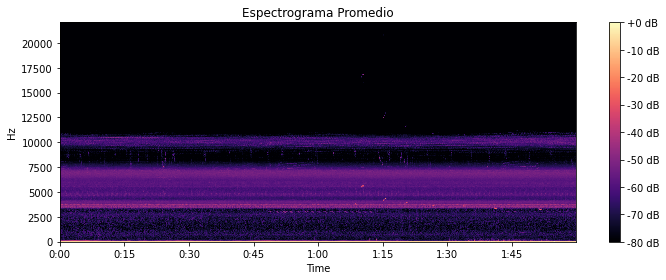

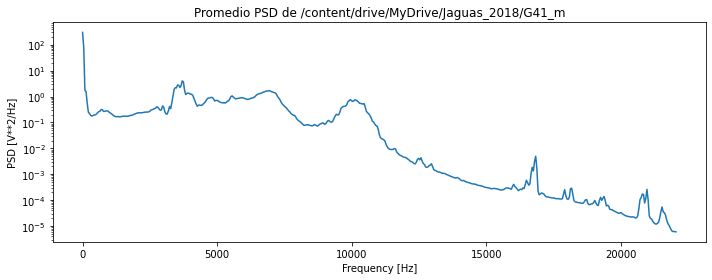

None archivos procesados en la carpeta /content/drive/MyDrive/Jaguas_2018/G41_m


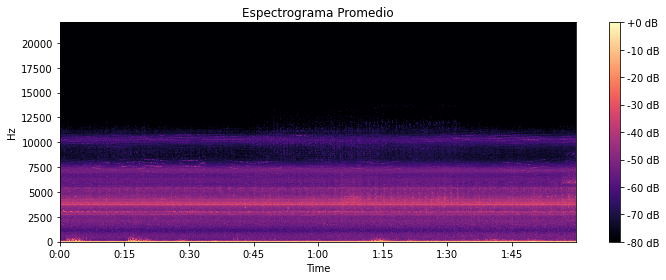

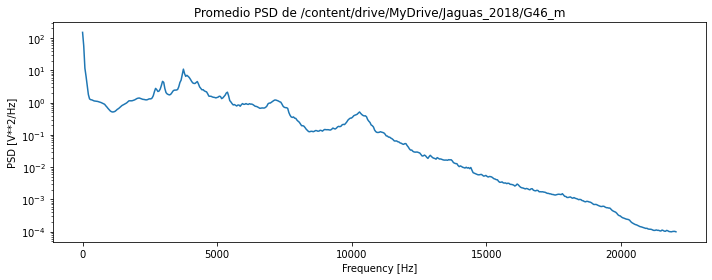

None archivos procesados en la carpeta /content/drive/MyDrive/Jaguas_2018/G46_m


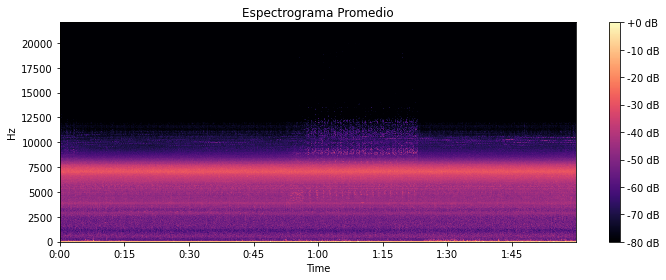

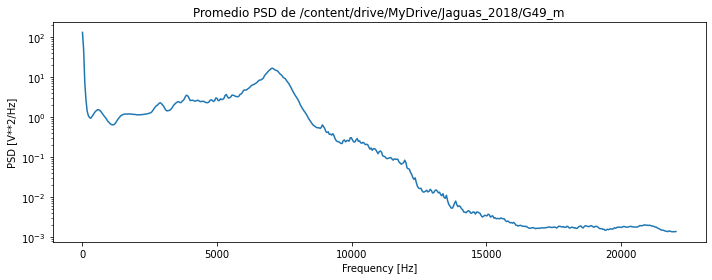

None archivos procesados en la carpeta /content/drive/MyDrive/Jaguas_2018/G49_m


In [ ]:
calcular_promedio_psd_en_carpetas(cantidad_audios=None, mostrar_espectrograma=True,
                          resample_rate=44100, nuevo_resample_rate=44100,
                          guardar_espectrograma=True, shape=(513, 10336))


##Grabadoras

In [ ]:
import os
import shutil

path_to_audio_folders = '/content/drive/MyDrive/Jaguas_2018/'

for foldername in os.listdir(path_to_audio_folders):
    if os.path.isdir(os.path.join(path_to_audio_folders, foldername)):
        folder_audio_count = 0
        folder_path = os.path.join(path_to_audio_folders, foldername)
        
        print('Carpeta:', foldername)
        
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav'):
                folder_audio_count += 1
        
        print('Cantidad de archivos de audio:', folder_audio_count)


Carpeta: G41_m
Cantidad de archivos de audio: 553
Carpeta: G46_m
Cantidad de archivos de audio: 735
Carpeta: G49_m
Cantidad de archivos de audio: 801
Carpeta: G58_m
Cantidad de archivos de audio: 735
Carpeta: G52_m
Cantidad de archivos de audio: 465
Carpeta: G50_m
Cantidad de archivos de audio: 620
Carpeta: G54_m
Cantidad de archivos de audio: 576
Carpeta: G47_m
Cantidad de archivos de audio: 804
Carpeta: G51_m
Cantidad de archivos de audio: 408
Carpeta: G57_m
Cantidad de archivos de audio: 621
Carpeta: G25_m
Cantidad de archivos de audio: 645
Carpeta: G27_m
Cantidad de archivos de audio: 644
Carpeta: G29_m
Cantidad de archivos de audio: 553
Carpeta: G35_m
Cantidad de archivos de audio: 627
Carpeta: G34_m
Cantidad de archivos de audio: 664
Carpeta: G24_m
Cantidad de archivos de audio: 555
Carpeta: G40_m
Cantidad de archivos de audio: 555
Carpeta: G36_m
Cantidad de archivos de audio: 545
Carpeta: G37_m
Cantidad de archivos de audio: 541
Carpeta: G28_m
Cantidad de archivos de audio: 553
